In [116]:
import sys
sys.path.append("../")

from src.common_functions import *

In [117]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sys
import pandas as pd
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss

In [118]:
RAW_DATA_PATH = "../datasets/churn/e_commerce_churn.xlsx"
DATASET_NAME = Path(RAW_DATA_PATH).stem
df = pd.read_excel(RAW_DATA_PATH, sheet_name="E Comm")
df = df.rename(columns=dict(
    zip(df.columns, list(map(to_snake_case, df.columns)))))

print(df.shape[0])
df.churn.value_counts()/df.shape[0]*100

5630


churn
0    83.161634
1    16.838366
Name: count, dtype: float64

In [119]:
df.isna().any()


customer_id                        False
churn                              False
tenure                              True
preferred_login_device             False
city_tier                          False
warehouse_to_home                   True
preferred_payment_mode             False
gender                             False
hour_spend_on_app                   True
number_of_device_registered        False
prefered_order_cat                 False
satisfaction_score                 False
marital_status                     False
number_of_address                  False
complain                           False
order_amount_hike_fromlast_year     True
coupon_used                         True
order_count                         True
day_since_last_order                True
cashback_amount                    False
dtype: bool

In [120]:
df.head()

,customer_id,churn,tenure,preferred_login_device,city_tier,warehouse_to_home,preferred_payment_mode,gender,hour_spend_on_app,number_of_device_registered,prefered_order_cat,satisfaction_score,marital_status,number_of_address,complain,order_amount_hike_fromlast_year,coupon_used,order_count,day_since_last_order,cashback_amount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [121]:
y = "churn"

# some generic cleaning

COLUMNS_TO_DROP = []
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [122]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': list(range(6, 32, 4)),
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid, verbose = 1)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
4060 fits failed out of a total of 5040.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1680 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^

Best score: 0.8900534045393858
Best parameters: {'logistic__C': 100, 'logistic__penalty': 'l2', 'over__sampling_strategy': 0.5, 'pca__n_components': 30, 'under__sampling_strategy': 0.3}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['customer_id', 'tenure',
                                                   'city_tier',
                                                   'warehouse_to_home',
                                                   'hour_spend_on_app',
                                                   'number_of_device_registered',
                                                   'satisfaction_score',
                                                   'number_of_address',
                                                   'complain',
                                                   'order_amount_hike_fromlas...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['preferred_login_device',
                                                   'preferred_payment_mode',
                                                   'gender',
                                                   'prefered_order_cat',
                                                   'marital_status'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.3)),
                ('over', SMOTE(sampling_strategy=0.5)),
                ('pca', PCA(n_components=30)),
                ('logistic', LogisticRegression(C=100))])

In [123]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [124]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
86,0.3,0.4,6,1,l2,0.787819,0.020694
338,0.3,0.4,6,10,l2,0.780889,0.018130
590,0.3,0.4,6,100,l2,0.786378,0.020238
842,0.3,0.4,6,1000,l2,0.771689,0.014771
92,0.3,0.4,10,1,l2,0.852273,0.008710
...,...,...,...,...,...,...,...
1000,0.7,1.0,26,1000,l2,0.883884,0.013037
250,0.7,1.0,30,1,l2,0.886608,0.013287
502,0.7,1.0,30,10,l2,0.886299,0.009966
754,0.7,1.0,30,100,l2,0.885402,0.008890


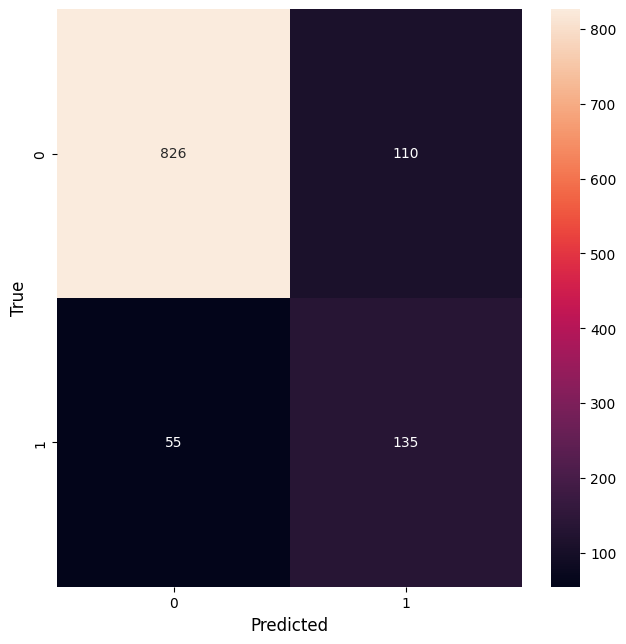

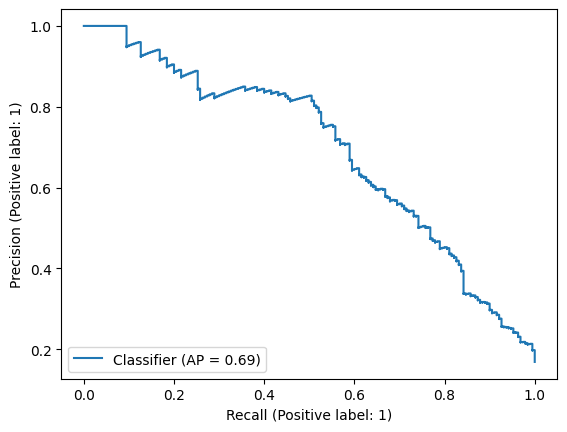

In [125]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name='logistic')

In [126]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized=True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.9198615698123815
Best parameters: {'xgb__subsample': 1.0, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 10, 'xgb__max_depth': 3, 'xgb__gamma': 2, 'xgb__colsample_bytree': 1.0, 'under__sampling_strategy': 0.3, 'pca__n_components': 35, 'over__sampling_strategy': 1}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['customer_id', 'tenure',
                                                   'city_tier',
                                                   'warehouse_to_home',
                                                   'hour_spend_on_app',
                                                   'number_of_device_registered',
                                                   'satisfaction_score',
                                                   'number_of_address',
                                                   'complain',
                                                   'order_amount_hike_fromlas...
                               feature_types=None, gamma=2, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [127]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

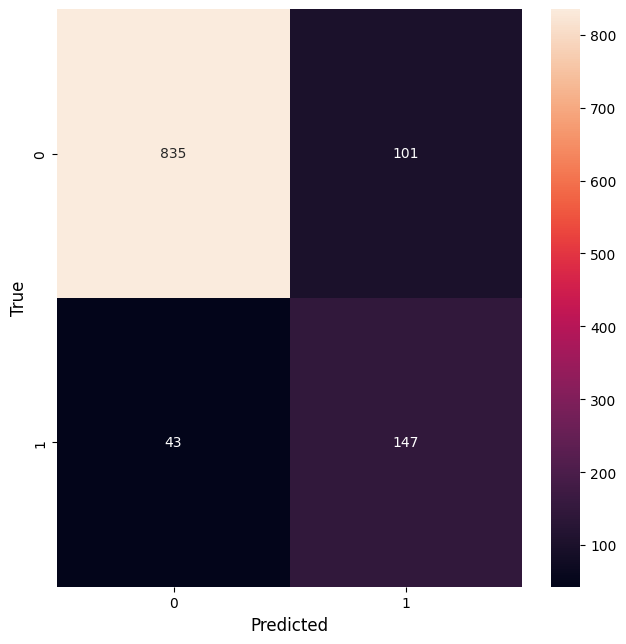

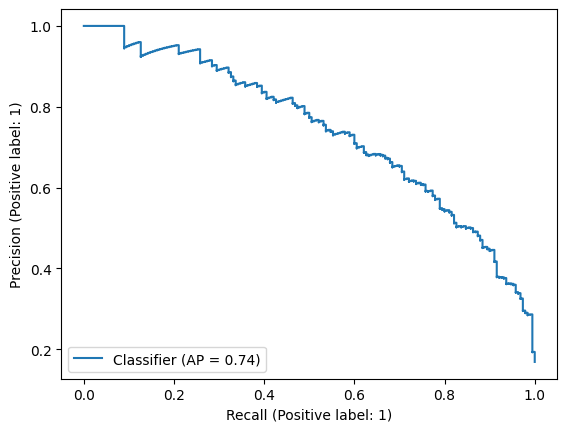

In [128]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

## Cost-based evaluation

In [129]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

In [130]:
# Step 2: Define a function to calculate the instance-dependent cost
def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    """
    Calculates the instance-dependent cost for a single instance.

    Parameters
    ----------
    prediction : int
        The predicted label.
    encoded_true_label : int
        The true label.
    a : float
        The cost of a false positive.

    Returns
    -------
    float
        The instance-dependent cost.
    """
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 0
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 2 * a
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return 12 * a

test_predictions = test.copy(deep=True)
test_predictions["y_predicted"] = best_pipeline_log_reg.predict(test_predictions.drop(y, axis=1))
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["churn"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions['A'] = impute.fit_transform(
    (test_predictions["order_count"]*test_predictions["tenure"]).to_frame())[:, 0]


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions['instance_cost'] = test_predictions.apply(lambda row: instance_dependent_cost(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions[['churn', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions['instance_cost'].sum():.0f}.")

Test cost/loss = 24774.


In [131]:
def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    """
    Calculates the instance-dependent cost for a single instance.

    Parameters
    ----------
    prediction : int
        The predicted label.
    encoded_true_label : int
        The true label.
    a : float
        The cost of a false positive.

    Returns
    -------
    float
        The instance-dependent cost.
    """
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 0
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 2 * a
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return 12 * a

test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["churn"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["order_count"]*test_predictions_xgb["tenure"]).to_frame())[:, 0]


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['churn', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")

Test cost/loss = 20256.


In [132]:
print(test_predictions[['churn', "A", 'instance_cost', 'y_predicted']].iloc[56:80])

      churn      A  instance_cost  y_predicted
4295      0   20.0            0.0            0
545       0    0.0            0.0            0
1937      0   60.0            0.0            0
4533      0    2.0            0.0            0
3202      0    2.0            0.0            0
1945      0   30.0            0.0            0
1103      0   14.0            0.0            0
5395      0   40.0            0.0            0
4763      0   38.0            0.0            0
3509      0    4.0            0.0            0
2457      1    1.0           12.0            0
4041      0  110.0            0.0            0
2027      0    5.0            0.0            0
2486      0   18.0            0.0            0
2443      0   26.0            0.0            0
3043      0   77.0            0.0            0
1788      1    0.0            0.0            1
1972      0   18.0            0.0            0
4725      0    2.0            0.0            0
4641      0   16.0            0.0            0
4241      0  

# 3.1 E-AMC evaluation metric

 # expected average profit and expected profit

In [133]:
cb_column = 'cb'
test[cb_column]= -(test["order_count"]*test["tenure"])

test['TN'] = 0
test['FN'] = 12* test[cb_column]
test['FP'] = 2* test[cb_column] 
test['TP'] = 0 

test = add_eap_ep(train, test, y, best_pipeline_log_reg, cb_column)
test_xgb = add_eap_ep(train, test, y, best_pipeline_xgb, cb_column)

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP']= test_actual_label_0['prob_churn']*test_actual_label_0['FP']+(1-test_actual_label_0['prob_churn'])*test_actual_label_0['TN']
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [134]:
test

,customer_id,churn,tenure,preferred_login_device,city_tier,warehouse_to_home,preferred_payment_mode,gender,hour_spend_on_app,number_of_device_registered,...,day_since_last_order,cashback_amount,cb,TN,FN,FP,TP,prob_churn,EAP,EP
2959,52960,0,10.0,Mobile Phone,1,13.0,Debit Card,Male,3.0,4,...,12.0,157.10,-110.0,0,-1320.0,-220.0,0,0.110065,-14.313763,-37.024867
3157,53158,0,11.0,Computer,3,16.0,Credit Card,Male,4.0,4,...,NaN,213.34,-88.0,0,-1056.0,-176.0,0,0.137393,-70.848283,-29.619893
2612,52613,0,7.0,Computer,3,16.0,Debit Card,Male,2.0,3,...,7.0,140.01,-7.0,0,-84.0,-14.0,0,0.054592,-3.123946,-2.356128
1463,51464,0,9.0,Phone,1,9.0,Debit Card,Female,NaN,3,...,0.0,128.35,-9.0,0,-108.0,-18.0,0,0.058813,-0.769898,-3.029307
5449,55450,0,12.0,Computer,2,9.0,UPI,Male,4.0,4,...,9.0,150.92,-48.0,0,-576.0,-96.0,0,0.122542,-14.491918,-16.156306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,54775,1,1.0,Computer,1,12.0,Credit Card,Female,3.0,5,...,8.0,148.66,-2.0,0,-24.0,-4.0,0,0.834441,-10.527685,-19.960924
2827,52828,1,1.0,Mobile Phone,1,12.0,COD,Male,3.0,4,...,3.0,159.41,-3.0,0,-36.0,-6.0,0,0.980694,-2.912048,-29.941385
531,50532,1,0.0,Phone,1,31.0,Debit Card,Male,NaN,3,...,1.0,127.95,-0.0,0,-0.0,-0.0,0,0.936294,0.000000,0.000000
202,50203,1,2.0,Mobile Phone,3,9.0,Credit Card,Female,2.0,3,...,0.0,152.38,-2.0,0,-24.0,-4.0,0,0.470665,-11.452872,-19.960924


In [135]:
print(test['EAP'].sum())
print(test['EP'].sum())


print('EAP : ', test['EAP'].sum()/len(test))
print('EP : ', test['EP'].sum()/len(test))

-26578.316742141986
-33044.90763765542
EAP :  -23.604188936182936
EP :  -29.34716486470286


In [136]:
print(test_xgb['EAP'].sum())
print(test_xgb['EP'].sum())


print('EAP : ', test_xgb['EAP'].sum()/len(test))
print('EP : ', test_xgb['EP'].sum()/len(test))

-21165.21419137576
-33044.90763765542
EAP :  -18.796815445271545
EP :  -29.34716486470286


In [137]:
test_predictions = test.copy(deep=True)
test_predictions["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test_predictions.drop(y, axis=1))[:, 1]
test_predictions["churn_encoded"] = fit_le.transform(test_predictions[y])

test_predictions['cb']= test_predictions["order_count"] * test_predictions["tenure"]
# impute = SimpleImputer(strategy='median')
train[y].value_counts()
label_mapper = {'stayed': 0, 'churned': 1}
# train['y_encoded'] = train[y].map(label_mapper)
# test['y_encoded'] = test[y].map(label_mapper)

# print(train['y_encoded'])
# print(test['y_encoded'])
train['y_encoded'] = train[y]
test['y_encoded'] = test[y]
print(test['y_encoded'])
print(train['y_encoded'])

2959    0
3157    0
2612    0
1463    0
5449    0
       ..
4774    1
2827    1
531     1
202     1
1579    1
Name: y_encoded, Length: 1126, dtype: int64
4999    0
3055    0
1296    0
2838    1
4053    0
       ..
2330    1
4974    0
1531    0
4220    0
3617    0
Name: y_encoded, Length: 4504, dtype: int64


# 3.2 AMC metric

Decision Threshold: 0.01, Test cost/loss = 52698.00
Decision Threshold: 0.02, Test cost/loss = 46954.00
Decision Threshold: 0.03, Test cost/loss = 46402.00
Decision Threshold: 0.04, Test cost/loss = 41094.00
Decision Threshold: 0.05, Test cost/loss = 40360.00
Decision Threshold: 0.06, Test cost/loss = 37974.00
Decision Threshold: 0.07, Test cost/loss = 34598.00


Decision Threshold: 0.08, Test cost/loss = 33964.00
Decision Threshold: 0.09, Test cost/loss = 33156.00
Decision Threshold: 0.10, Test cost/loss = 35810.00
Decision Threshold: 0.11, Test cost/loss = 36680.00
Decision Threshold: 0.12, Test cost/loss = 35708.00
Decision Threshold: 0.13, Test cost/loss = 35210.00
Decision Threshold: 0.14, Test cost/loss = 35846.00
Decision Threshold: 0.15, Test cost/loss = 35160.00
Decision Threshold: 0.16, Test cost/loss = 33844.00
Decision Threshold: 0.17, Test cost/loss = 33910.00
Decision Threshold: 0.18, Test cost/loss = 33736.00
Decision Threshold: 0.19, Test cost/loss = 33380.00
Decision Threshold: 0.20, Test cost/loss = 31712.00
Decision Threshold: 0.21, Test cost/loss = 31426.00
Decision Threshold: 0.22, Test cost/loss = 30254.00
Decision Threshold: 0.23, Test cost/loss = 29714.00
Decision Threshold: 0.24, Test cost/loss = 29546.00
Decision Threshold: 0.25, Test cost/loss = 29424.00
Decision Threshold: 0.26, Test cost/loss = 29208.00
Decision Thr

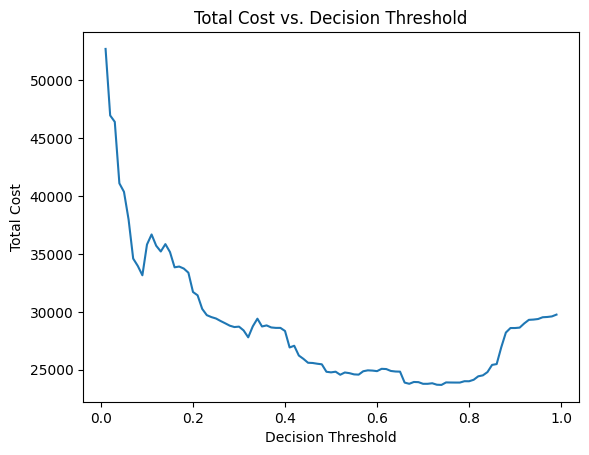

(0.74, 21.039076376554174, 23690.0)

In [138]:
def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    """Calculates the instance-dependent cost for a single prediction."""
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return  0  
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 2 * a  # Switched cost for TN
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)
        return  0   # Switched cost for FP
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return 12 * a 

test_predictions = test.copy(deep=True)
test_predictions["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test_predictions.drop(y, axis=1))[:, 1]
test_predictions["churn_encoded"] = fit_le.transform(test_predictions[y])

test_predictions['cb']= test_predictions["order_count"] * test_predictions["tenure"]
# impute = SimpleImputer(strategy='median')
train[y].value_counts()
label_mapper = {'stayed': 0, 'churned': 1}
train['y_encoded'] = train[y].map(label_mapper)
test['y_encoded'] = test[y].map(label_mapper)
# train['y_encoded'] = train[y]
# test['y_encoded'] = test[y]

def compute_best_threshold(test, log_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test['y_predicted_proba']= log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test['instance_cost'] = -test.apply(lambda row: instance_dependent_cost(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, Lowest Test cost/loss = {lowest_cost:.2f}, Lowest AMC = {AMC:.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test, best_pipeline_log_reg, y, 'cb')


Decision Threshold: 0.01, Test cost/loss = 47554.00
Decision Threshold: 0.02, Test cost/loss = 37696.00
Decision Threshold: 0.03, Test cost/loss = 33186.00
Decision Threshold: 0.04, Test cost/loss = 30942.00
Decision Threshold: 0.05, Test cost/loss = 28720.00
Decision Threshold: 0.06, Test cost/loss = 27252.00
Decision Threshold: 0.07, Test cost/loss = 26040.00
Decision Threshold: 0.08, Test cost/loss = 24380.00
Decision Threshold: 0.09, Test cost/loss = 22890.00
Decision Threshold: 0.10, Test cost/loss = 21822.00
Decision Threshold: 0.11, Test cost/loss = 22304.00
Decision Threshold: 0.12, Test cost/loss = 21416.00
Decision Threshold: 0.13, Test cost/loss = 20654.00
Decision Threshold: 0.14, Test cost/loss = 19788.00
Decision Threshold: 0.15, Test cost/loss = 19896.00
Decision Threshold: 0.16, Test cost/loss = 19818.00
Decision Threshold: 0.17, Test cost/loss = 18966.00
Decision Threshold: 0.18, Test cost/loss = 22280.00
Decision Threshold: 0.19, Test cost/loss = 21362.00
Decision Thr

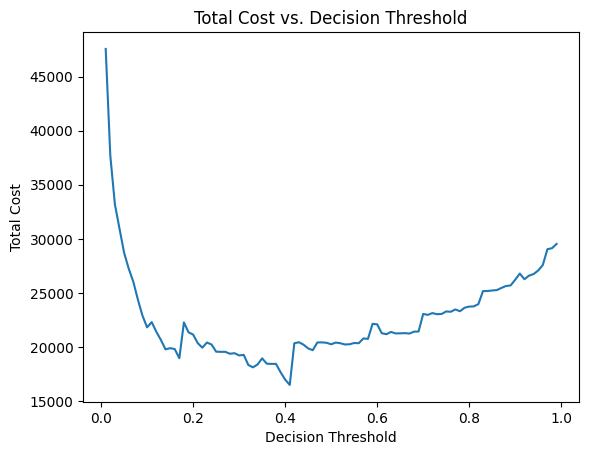

(0.41000000000000003, 14.653641207815275, 16500.0)

In [139]:
def compute_best_threshold(test, xgb_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test_xgb['y_predicted_proba']= xgb_best.predict_proba(test_xgb.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test_xgb['instance_cost'] = -test_xgb.apply(lambda row: instance_dependent_cost(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test_xgb['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, Lowest Test cost/loss = {lowest_cost:.2f}, Lowest AMC = {AMC:.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test_xgb, best_pipeline_xgb, y, 'cb')

In [140]:
print(test['y_encoded'])
print(test[y])
print(test['y_encoded'].value_counts())

2959   NaN
3157   NaN
2612   NaN
1463   NaN
5449   NaN
        ..
4774   NaN
2827   NaN
531    NaN
202    NaN
1579   NaN
Name: y_encoded, Length: 1126, dtype: float64
2959    0
3157    0
2612    0
1463    0
5449    0
       ..
4774    1
2827    1
531     1
202     1
1579    1
Name: churn, Length: 1126, dtype: int64
Series([], Name: count, dtype: int64)


# mp metric

In [141]:
def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    """Calculates the instance-dependent cost for a single prediction."""
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return  0  
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 2 * a  # Switched cost for TN
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)
        return  0   # Switched cost for FP
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return 12 * a 

In [142]:
# CLV(𝛿 + 𝜙) ⋅ 𝜋0F0(T)−(CLV(𝛾(1 − 𝛿) − 𝜙)) ⋅ 𝜋1F1(T)
# + (CLV(𝛾(1 − 𝛿) − 𝜙)) ⋅ 𝜋1 − CLV(𝛿 + 𝜙) ⋅ 𝜋0

# 𝜋1 = log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# 𝜋0 = 1 - 𝜋1
# k = d/clv

# l = f/clv

# 𝜆 = (1 - F1) / 𝜂

# 𝜂 = 1 - (𝜋0F0 + 𝜋1F1).
# 𝛾 = 

# b1 = clv* (𝛾(1 - k) - l)



In [143]:
df['cashback_amount'].mean()

177.22303019538188

In [144]:

test_predictions = test.copy(deep=True)
test_predictions["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test_predictions.drop(y, axis=1))[:, 1]
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["churn"])
def __empRocInfo(probability_scores, true_class_labels):
    
    # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
    arguments_list = [test_predictions['y_predicted_proba'], test_predictions["churn_encoded"]]
    factor_array = []
    n_0 = 0
    number_of_factors = 0
    
    def linear_line(m, x, b):
        return m*x + b
    
    
    for i in range(0, len(arguments_list)):
        if (type(arguments_list[i]) == pd.Series):
            arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
        if (type(arguments_list[i]) == np.matrix):
            arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
        if (type(arguments_list[i]) == list):
            arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] not in factor_array):
            factor_array.append(arguments_list[1][i])
            number_of_factors = number_of_factors + 1
            
    if (number_of_factors > 2):
        sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


    ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

    if (len(arguments_list[0]) != len(arguments_list[1])):
        sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

### Checking that there are no invalid probabilities in the probability scores array ###

    for i in range(0, len(arguments_list[0])):
        if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
            sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

### Counting the number of positive cases in the true class values array ###

    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] == 1):
            n_0 +=  1
            
### Calculating metrics ###

    total_number_of_observations = len(arguments_list[1])
    n_1 = total_number_of_observations - n_0
    pi_1 = n_1 / total_number_of_observations
    pi_0 = n_0 / total_number_of_observations
    fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
    roc_output = np.c_[fpr, tpr]
    hull = ConvexHull(roc_output)
    vertices = []
    
    for k in hull.vertices:
        if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
            vertices.append(k)
            
    F_1 = roc_output[vertices, 0]
    F_1 = np.sort(F_1)
    F_0 = roc_output[vertices, 1]
    F_0 = np.sort(F_0)
    
    return n_0, n_1, pi_0, pi_1, F_0, F_1











In [145]:

test_predictions = test.copy(deep=True)
test_predictions["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test_predictions.drop(y, axis=1))[:, 1]
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["churn"])

def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
    def B(a, b, X):
        
        
        return betainc(a, b, X)* ss.beta(a, b)

        ### Initializing constants and variables for rest of function ###

    roc = __empRocInfo(test_predictions["y_predicted_proba"], test_predictions["churn_encoded"])
    E_GAMMA = alpha / (alpha + beta)
    DELTA = d / clv
    PHI = f / clv
        
    ### Calculating MP and MP fraction ###
    '''
    n_0, n_1, pi_0, pi_1, F_0, F_1
    gamma values = pi_0 (delta * phi)
    '''
    gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
    gamma_values = np.append(gamma_values[gamma_values < 1], 1)
    ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
    MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
    MP_fraction = roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E]

    ### Calculating EMP and EMP fraction ###

    gammaii = gamma_values[range(0, len(gamma_values) - 1)]
    gammaie = gamma_values[range(1, len(gamma_values))]
    F_0 = (roc[4])[range(0, len(gammaii))]
    F_1 = (roc[5])[range(0, len(gammaii))]
    contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
    contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
    EMP = np.sum(contr_0 + contr_1)
    EMP_fraction = np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1))

    ### Formatting output ###

    if rounding != None:
        MP = np.round(MP, decimals = rounding)
        MP_fraction = np.round(MP_fraction, decimals = rounding)
        EMP = np.round(EMP, decimals = rounding)
        EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
    output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
    output = output(MP, MP_fraction, EMP, EMP_fraction)
        
    if print_output:
        print("******************************************************************************")
        print("EMP Churn Output")
        print("******************************************************************************")
        print("MP: ", MP)
        print("")
        print("MP Fraction: ", MP_fraction)
        print("")
        print("EMP: ", EMP)
        print("")
        print("EMP Fraction: ", EMP_fraction)

    
            
    if return_output:
        return output

empChurn(test_predictions["y_predicted_proba"], test_predictions["churn_encoded"], alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None)


C:\Users\stijn\AppData\Local\Temp\ipykernel_23136\1515637981.py:25: RuntimeWarning: divide by zero encountered in divide
  gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))


output(MP=4.958468916518649, MP_fraction=0.25843694493783304, EMP=5.023947904930741, EMP_fraction=0.2487690755434779)

In [146]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["churn"])
def __empRocInfo(probability_scores, true_class_labels):
    
    # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
    arguments_list = [test_predictions_xgb['y_predicted_proba'], test_predictions_xgb["churn_encoded"]]
    factor_array = []
    n_0 = 0
    number_of_factors = 0
    
    def linear_line(m, x, b):
        return m*x + b
    
    
    for i in range(0, len(arguments_list)):
        if (type(arguments_list[i]) == pd.Series):
            arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
        if (type(arguments_list[i]) == np.matrix):
            arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
        if (type(arguments_list[i]) == list):
            arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] not in factor_array):
            factor_array.append(arguments_list[1][i])
            number_of_factors = number_of_factors + 1
            
    if (number_of_factors > 2):
        sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


    ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

    if (len(arguments_list[0]) != len(arguments_list[1])):
        sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

### Checking that there are no invalid probabilities in the probability scores array ###

    for i in range(0, len(arguments_list[0])):
        if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
            sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

### Counting the number of positive cases in the true class values array ###

    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] == 1):
            n_0 +=  1
            
### Calculating metrics ###

    total_number_of_observations = len(arguments_list[1])
    n_1 = total_number_of_observations - n_0
    pi_1 = n_1 / total_number_of_observations
    pi_0 = n_0 / total_number_of_observations
    fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
    roc_output = np.c_[fpr, tpr]
    hull = ConvexHull(roc_output)
    vertices = []
    
    for k in hull.vertices:
        if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
            vertices.append(k)
            
    F_1 = roc_output[vertices, 0]
    F_1 = np.sort(F_1)
    F_0 = roc_output[vertices, 1]
    F_0 = np.sort(F_0)
    
    return n_0, n_1, pi_0, pi_1, F_0, F_1






In [147]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["churn"])

def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
    def B(a, b, X):
        
        
        return betainc(a, b, X)* ss.beta(a, b)

        ### Initializing constants and variables for rest of function ###

    roc = __empRocInfo(test_predictions_xgb["y_predicted_proba"], test_predictions_xgb["churn_encoded"])
    E_GAMMA = alpha / (alpha + beta)
    DELTA = d / clv
    PHI = f / clv
        
    ### Calculating MP and MP fraction ###
    '''
    n_0, n_1, pi_0, pi_1, F_0, F_1
    gamma values = pi_0 (delta * phi)
    '''
    gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
    gamma_values = np.append(gamma_values[gamma_values < 1], 1)
    ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
    MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
    MP_fraction = roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E]

    ### Calculating EMP and EMP fraction ###

    gammaii = gamma_values[range(0, len(gamma_values) - 1)]
    gammaie = gamma_values[range(1, len(gamma_values))]
    F_0 = (roc[4])[range(0, len(gammaii))]
    F_1 = (roc[5])[range(0, len(gammaii))]
    contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
    contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
    EMP = np.sum(contr_0 + contr_1)
    EMP_fraction = np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1))

    ### Formatting output ###

    if rounding != None:
        MP = np.round(MP, decimals = rounding)
        MP_fraction = np.round(MP_fraction, decimals = rounding)
        EMP = np.round(EMP, decimals = rounding)
        EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
    output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
    output = output(MP, MP_fraction, EMP, EMP_fraction)
        
    if print_output:
        print("******************************************************************************")
        print("EMP Churn Output")
        print("******************************************************************************")
        print("MP: ", MP)
        print("")
        print("MP Fraction: ", MP_fraction)
        print("")
        print("EMP: ", EMP)
        print("")
        print("EMP Fraction: ", EMP_fraction)

    
            
    if return_output:
        return output

empChurn(test_predictions_xgb["y_predicted_proba"], test_predictions_xgb["churn_encoded"], alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None)


C:\Users\stijn\AppData\Local\Temp\ipykernel_23136\836916586.py:25: RuntimeWarning: divide by zero encountered in divide
  gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))


output(MP=5.567989342806395, MP_fraction=0.30017761989342806, EMP=5.636122225309878, EMP_fraction=0.27620526931470235)